<a href="https://colab.research.google.com/github/khykelly-cloud/mul/blob/main/MILP_VRP_%EC%9C%A0%ED%81%B4%EB%A6%AC%EB%93%9C%EB%A7%A8%ED%95%B4%ED%8A%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ortools



==================== Euclidean VRP ====================

🚚 DC 0 VRP 계산 중...
📌 VRP 총 거리: 59
📌 Routes:
    [0, 1, 4, 2, 5, 3, 0]


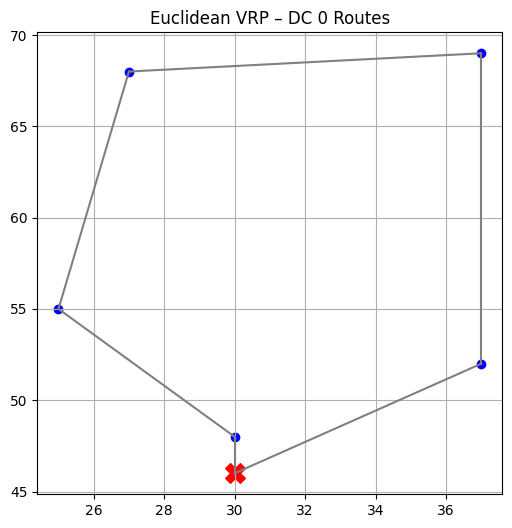


🚚 DC 1 VRP 계산 중...
📌 VRP 총 거리: 69
📌 Routes:
    [0, 7, 1, 3, 5, 6, 2, 4, 0]


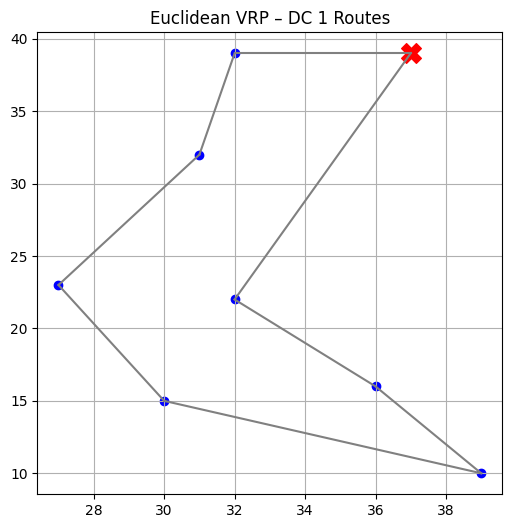


🚚 DC 2 VRP 계산 중...
📌 VRP 총 거리: 225
📌 Routes:
    [0, 11, 17, 16, 12, 18, 20, 0]
    [0, 1, 14, 5, 7, 2, 19, 6, 13, 0]
    [0, 10, 15, 8, 4, 3, 9, 0]


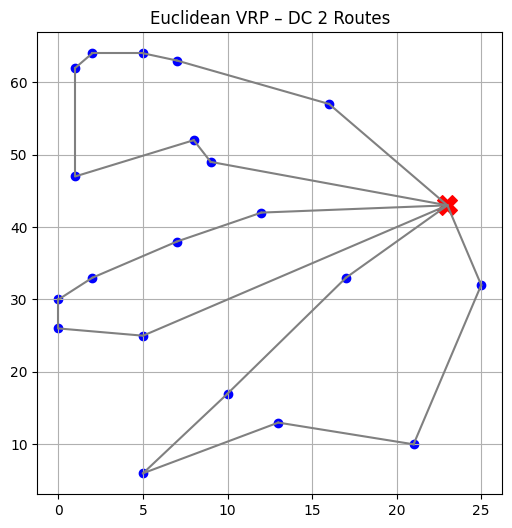


🚚 DC 3 VRP 계산 중...
📌 VRP 총 거리: 138
📌 Routes:
    [0, 2, 3, 10, 9, 5, 4, 0]
    [0, 13, 8, 6, 11, 7, 1, 12, 0]


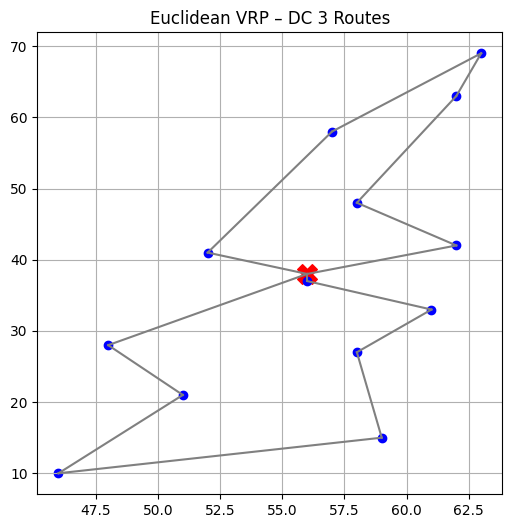


🚚 DC 4 VRP 계산 중...
📌 VRP 총 거리: 65
📌 Routes:
    [0, 5, 1, 4, 2, 3, 0]


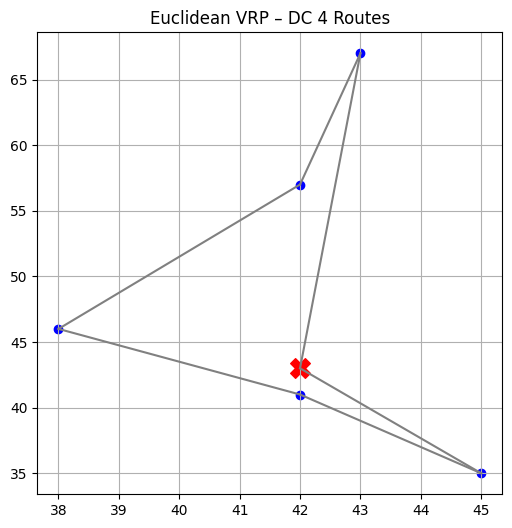


==================== Manhattan VRP ====================

🚚 DC 0 VRP 계산 중...
📌 VRP 총 거리: 132
📌 Routes:
    [0, 3, 6, 2, 4, 1, 5, 0]


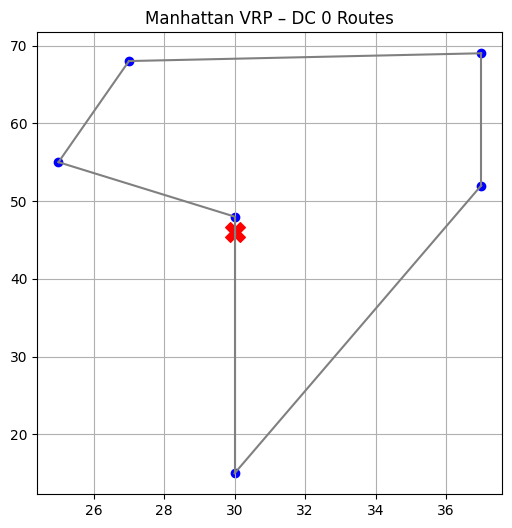


🚚 DC 1 VRP 계산 중...
📌 VRP 총 거리: 74
📌 Routes:
    [0, 5, 1, 3, 2, 4, 0]


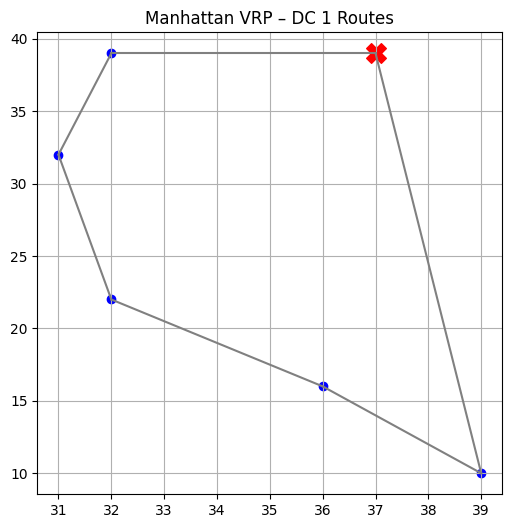


🚚 DC 2 VRP 계산 중...
📌 VRP 총 거리: 308
📌 Routes:
    [0, 12, 19, 11, 21, 0]
    [0, 14, 6, 20, 2, 7, 5, 15, 1, 0]
    [0, 10, 16, 8, 4, 3, 9, 17, 13, 18, 0]


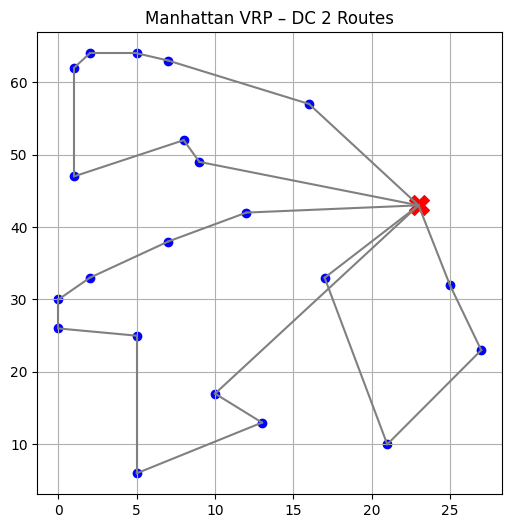


🚚 DC 3 VRP 계산 중...
📌 VRP 총 거리: 156
📌 Routes:
    [0, 2, 0]
    [0, 12, 11, 1, 10, 6, 7, 4, 8, 9, 3, 5, 0]


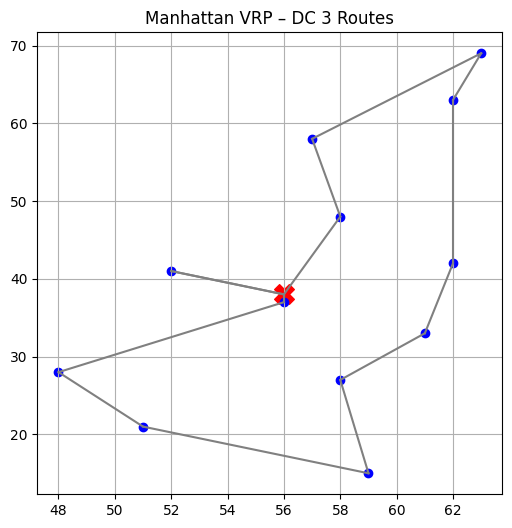


🚚 DC 4 VRP 계산 중...
📌 VRP 총 거리: 130
📌 Routes:
    [0, 4, 2, 3, 6, 5, 1, 0]


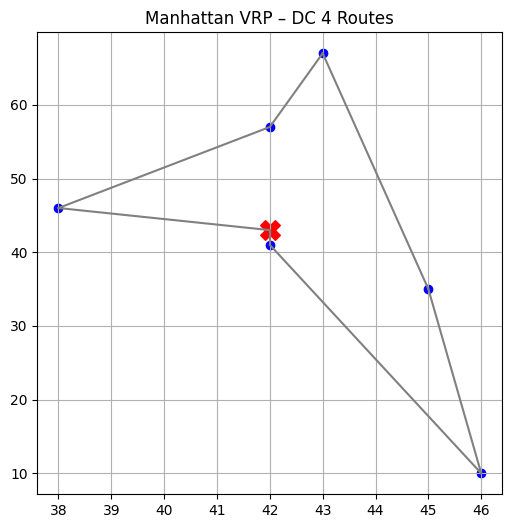

In [3]:
# =====================================================
# CASE 0 + VRP (Euclidean & Manhattan) + Visualization
# =====================================================

!pip install ortools --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# --------------------------------------------
# 1) Load CSV
# --------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

TRUCK_CAPACITY = truck["CAPACITY"].iloc[0]

# --------------------------------------------
# 2) Distance functions
# --------------------------------------------
def euclidean(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

# --------------------------------------------
# 3) 고객 → 가장 가까운 센터 배정 (Euclid & Manhattan 각각)
# --------------------------------------------
def assign_customers(distance_func):
    assignments = []
    opened_centers = set()

    for _, row in customer.iterrows():
        cx, cy = row["X"], row["Y"]

        best_dc = None
        best_dist = float("inf")

        for _, drow in dc.iterrows():
            dx, dy = drow["X"], drow["Y"]
            dist = distance_func((cx, cy), (dx, dy))

            if dist < best_dist:
                best_dist = dist
                best_dc = drow["DC_ID"]

        assignments.append([row["Customer_ID"], best_dc, best_dist])
        opened_centers.add(best_dc)

    return pd.DataFrame(assignments, columns=["Customer_ID","Assigned_DC","Distance"]), opened_centers


assign_euc, opened_euc = assign_customers(euclidean)
assign_man, opened_man = assign_customers(manhattan)


# =====================================================
#         VRP 기능 함수 정의 (OR-Tools)
# =====================================================

def solve_vrp(data, dist_matrix):
    manager = pywrapcp.RoutingIndexManager(
        len(dist_matrix), data["num_vehicles"], data["depot"]
    )
    routing = pywrapcp.RoutingModel(manager)

    # 거리 callback
    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return int(dist_matrix[f][t])

    transit_callback = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback)

    # 용량 제약
    def demand_callback(from_idx):
        return data["demands"][manager.IndexToNode(from_idx)]

    demand_callback_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_idx,
        0,
        [data["vehicle_capacity"]] * data["num_vehicles"],
        True,
        "Capacity"
    )

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    solution = routing.SolveWithParameters(params)

    if not solution:
        return None, None

    total_distance = 0
    routes = []

    for v in range(data["num_vehicles"]):
        idx = routing.Start(v)
        route = []

        while not routing.IsEnd(idx):
            route.append(manager.IndexToNode(idx))
            prev = idx
            idx = solution.Value(routing.NextVar(idx))
            total_distance += routing.GetArcCostForVehicle(prev, idx, v)

        route.append(manager.IndexToNode(idx))
        if len(route) > 2:  # 차량이 고객을 방문했을 때만 출력
            routes.append(route)

    return total_distance, routes


# =====================================================
#    VRP 실행 + 시각화 함수 (유클리드/맨해튼 공용)
# =====================================================

def run_vrp_and_plot(assign_df, opened_centers, distance_func, title):
    print("\n====================", title, "====================")

    for dc_id in opened_centers:
        print(f"\n🚚 DC {dc_id} VRP 계산 중...")

        cust_ids = assign_df[assign_df["Assigned_DC"] == dc_id]["Customer_ID"].tolist()
        if len(cust_ids) == 0:
            continue

        # 좌표 나열
        locations = []
        dc_row = dc[dc["DC_ID"] == dc_id].iloc[0]
        locations.append((dc_row["X"], dc_row["Y"]))  # depot

        for cid in cust_ids:
            row = customer[customer["Customer_ID"] == cid].iloc[0]
            locations.append((row["X"], row["Y"]))

        # 거리행렬
        n = len(locations)
        dist_matrix = [[0]*n for _ in range(n)]

        for i in range(n):
            for j in range(n):
                dist_matrix[i][j] = distance_func(locations[i], locations[j])

        # demands
        demands = [0]  # depot
        for cid in cust_ids:
            dem = customer[customer["Customer_ID"] == cid]["DEMAND"].iloc[0]
            demands.append(dem)

        data = {
            "demands": demands,
            "num_vehicles": 5,
            "vehicle_capacity": TRUCK_CAPACITY,
            "depot": 0
        }

        total_dist, routes = solve_vrp(data, dist_matrix)

        print(f"📌 VRP 총 거리: {total_dist}")
        print("📌 Routes:")
        for r in routes:
            print("   ", r)

        # -----------------------------
        # 시각화
        # -----------------------------
        plt.figure(figsize=(6,6))
        plt.title(f"{title} – DC {dc_id} Routes")

        # depot
        plt.scatter(dc_row["X"], dc_row["Y"], c="red", marker="X", s=200, label="DC")

        # customers
        cust = assign_df[assign_df["Assigned_DC"] == dc_id]["Customer_ID"].tolist()
        for cid in cust:
            row = customer[customer["Customer_ID"] == cid].iloc[0]
            plt.scatter(row["X"], row["Y"], c="blue")

        # route lines
        for route in routes:
            for i in range(len(route)-1):
                x1, y1 = locations[route[i]]
                x2, y2 = locations[route[i+1]]
                plt.plot([x1, x2], [y1, y2], c="gray")

        plt.grid(True)
        plt.show()


# =====================================================
#   Euclidean VRP + Plot
# =====================================================
run_vrp_and_plot(assign_euc, opened_euc, euclidean, "Euclidean VRP")


# =====================================================
#   Manhattan VRP + Plot
# =====================================================
run_vrp_and_plot(assign_man, opened_man, manhattan, "Manhattan VRP")



================= Euclidean VRP =================


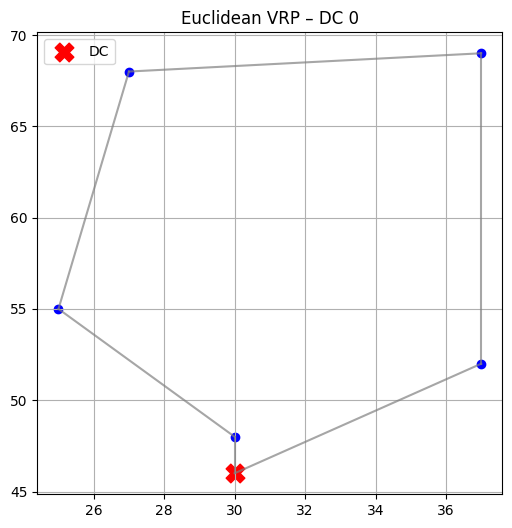

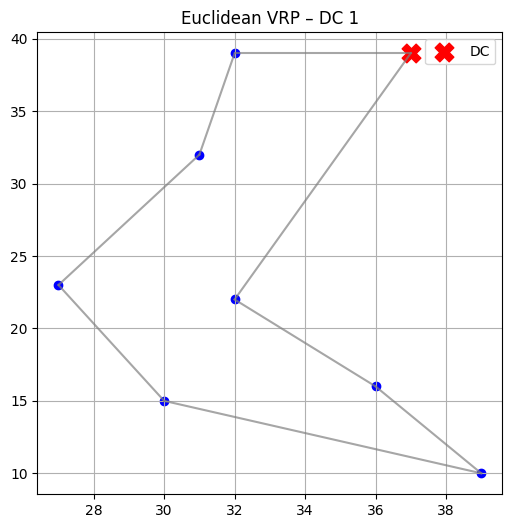

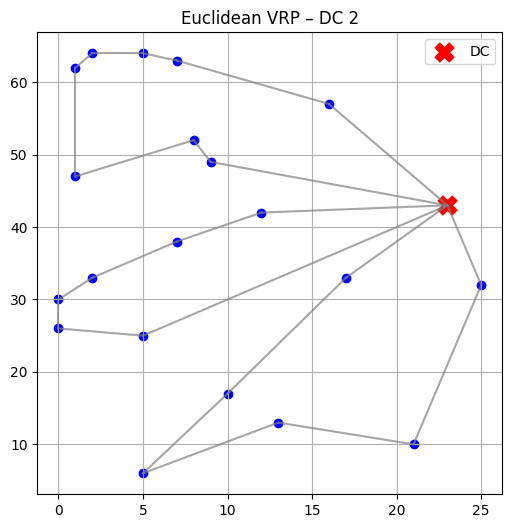

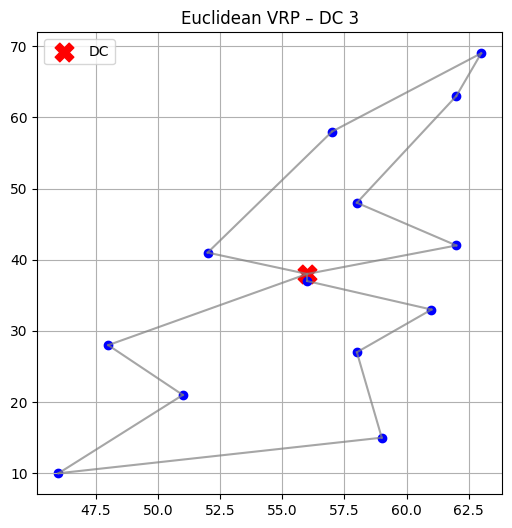

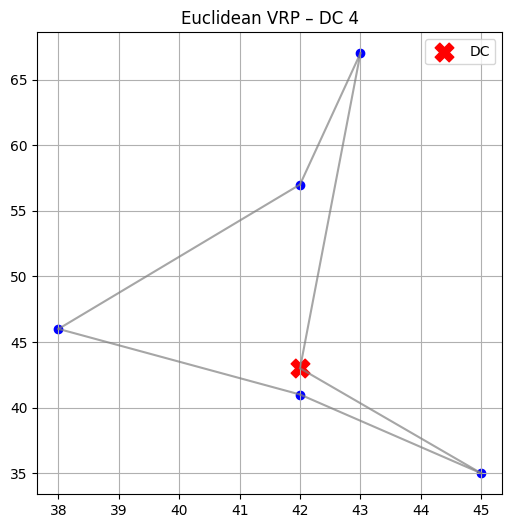


================= Manhattan VRP =================


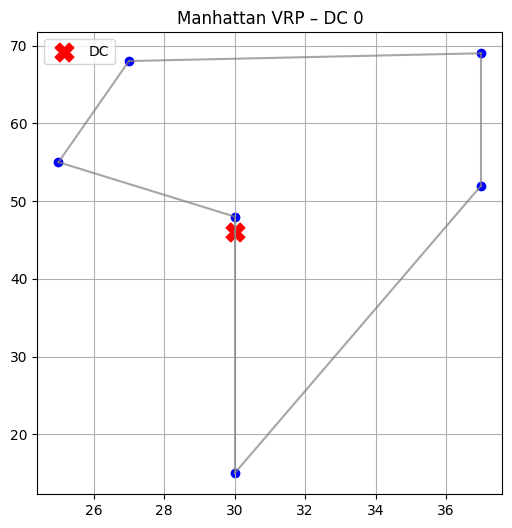

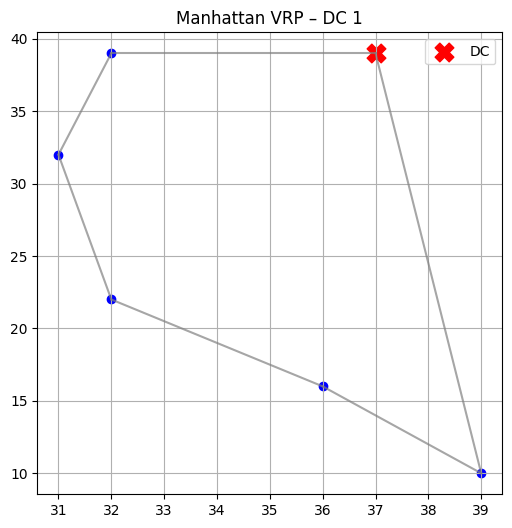

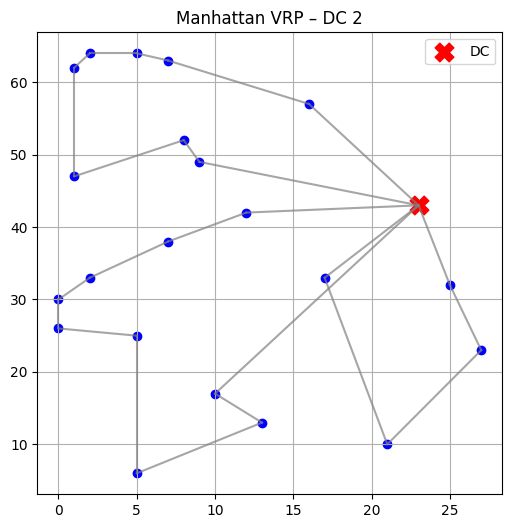

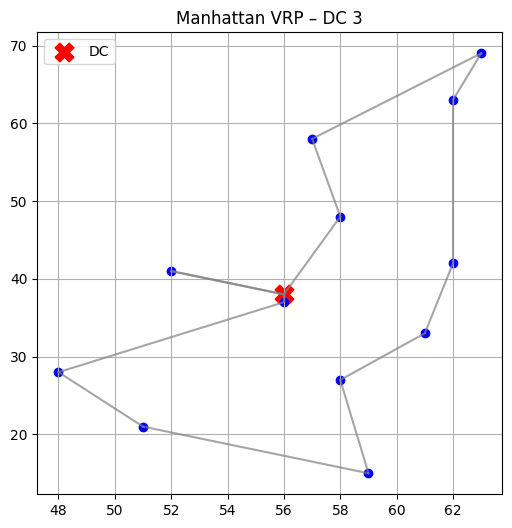

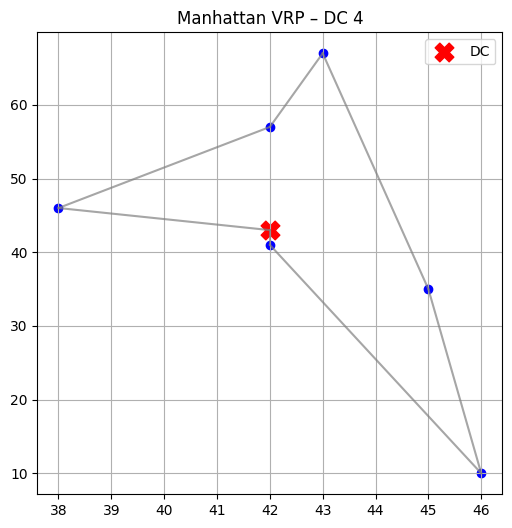


==================== 총 비용 비교 ====================
[Euclidean]
  개설센터: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
  개설비용: 200
  VRP 배송비: 556
  👉 총비용(Euclid): 756

[Manhattan]
  개설센터: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
  개설비용: 200
  VRP 배송비: 800
  👉 총비용(Manhattan): 1000


In [8]:
# =====================================================
# CASE 0 : 고객→센터 배정 + VRP + 총비용 계산 + 시각화
# (Euclidean & Manhattan 거리 모두)
# =====================================================

!pip install ortools --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# -----------------------------------------------------
# 1) CSV 불러오기
# -----------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

TRUCK_CAPACITY = truck["CAPACITY"].iloc[0]
OPEN_COST = dc["COST"].iloc[0]    # 개설비는 모두 동일 (40)

# -----------------------------------------------------
# 2) 거리 함수 (Euclidean / Manhattan)
# -----------------------------------------------------
def euclidean(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

# -----------------------------------------------------
# 3) 고객→센터 배정 함수
# -----------------------------------------------------
def assign_customers(distance_func):
    assignments = []
    opened_centers = set()

    for _, row in customer.iterrows():
        cx, cy = row["X"], row["Y"]

        best_dc = None
        best_dist = float("inf")

        for _, drow in dc.iterrows():
            dx, dy = drow["X"], drow["Y"]
            dist = distance_func((cx, cy), (dx, dy))

            if dist < best_dist:
                best_dist = dist
                best_dc = drow["DC_ID"]

        assignments.append([row["Customer_ID"], best_dc, best_dist])
        opened_centers.add(best_dc)

    return pd.DataFrame(assignments, columns=["Customer_ID","Assigned_DC","Distance"]), opened_centers


assign_euc, opened_euc = assign_customers(euclidean)
assign_man, opened_man = assign_customers(manhattan)

# -----------------------------------------------------
# 4) VRP 함수 정의
# -----------------------------------------------------
def solve_vrp(data, dist_matrix):
    manager = pywrapcp.RoutingIndexManager(
        len(dist_matrix), data["num_vehicles"], data["depot"]
    )
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return int(dist_matrix[f][t])

    transit_callback = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback)

    # 용량 제약
    def demand_callback(from_idx):
        return data["demands"][manager.IndexToNode(from_idx)]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx,
        0,
        [data["vehicle_capacity"]] * data["num_vehicles"],
        True,
        "Capacity"
    )

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.SolveWithParameters(params)

    if not solution:
        return None, None

    total_dist = 0
    routes = []

    for v in range(data["num_vehicles"]):
        idx = routing.Start(v)
        route = []

        while not routing.IsEnd(idx):
            route.append(manager.IndexToNode(idx))
            prev = idx
            idx = solution.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(prev, idx, v)

        route.append(manager.IndexToNode(idx))

        if len(route) > 2:
            routes.append(route)

    return total_dist, routes

# -----------------------------------------------------
# 5) VRP 수행 + 결과 저장 + 시각화 함수
# -----------------------------------------------------
def run_vrp(assign_df, opened_centers, distance_func, title):

    results = {}

    print(f"\n================= {title} =================")

    for dc_id in opened_centers:

        # 배정된 고객
        cust_ids = assign_df[assign_df["Assigned_DC"] == dc_id]["Customer_ID"].tolist()
        if len(cust_ids) == 0:
            continue

        # 위치 나열
        locations = []
        dc_row = dc[dc["DC_ID"] == dc_id].iloc[0]
        locations.append((dc_row["X"], dc_row["Y"]))  # depot

        for cid in cust_ids:
            row = customer[customer["Customer_ID"] == cid].iloc[0]
            locations.append((row["X"], row["Y"]))

        # 거리행렬 생성
        n = len(locations)
        dist_matrix = [[0]*n for _ in range(n)]
        for i in range(n):
            for j in range(n):
                dist_matrix[i][j] = distance_func(locations[i], locations[j])

        # 수요 리스트
        demands = [0]
        for cid in cust_ids:
            dem = customer[customer["Customer_ID"] == cid]["DEMAND"].iloc[0]
            demands.append(dem)

        data = {
            "demands": demands,
            "num_vehicles": 5,
            "vehicle_capacity": TRUCK_CAPACITY,
            "depot": 0
        }

        total_dist, routes = solve_vrp(data, dist_matrix)

        results[dc_id] = {
            "total_distance": total_dist,
            "routes": routes
        }

        # -----------------------------
        # 시각화
        # -----------------------------
        plt.figure(figsize=(6,6))
        plt.title(f"{title} – DC {dc_id}")

        plt.scatter(dc_row["X"], dc_row["Y"], c="red", marker="X", s=180, label="DC")

        for cid in cust_ids:
            row = customer[customer["Customer_ID"] == cid].iloc[0]
            plt.scatter(row["X"], row["Y"], c="blue")

        for route in routes:
            for i in range(len(route)-1):
                x1, y1 = locations[route[i]]
                x2, y2 = locations[route[i+1]]
                plt.plot([x1, x2], [y1, y2], c="gray", alpha=0.7)

        plt.grid(True)
        plt.legend()
        plt.show()

    return results


# -----------------------------------------------------
# 6) Euclidean VRP 실행
# -----------------------------------------------------
euclid_results = run_vrp(assign_euc, opened_euc, euclidean, "Euclidean VRP")

# -----------------------------------------------------
# 7) Manhattan VRP 실행
# -----------------------------------------------------
man_results = run_vrp(assign_man, opened_man, manhattan, "Manhattan VRP")

# -----------------------------------------------------
# 8) 총 비용 계산 (개설비 + VRP거리)
# -----------------------------------------------------
def compute_total_cost(opened_set, vrp_results):

    open_cost = len(opened_set) * OPEN_COST

    route_cost = 0
    for dc_id in vrp_results:
        route_cost += vrp_results[dc_id]["total_distance"]

    return open_cost, route_cost, open_cost + route_cost


ec_open, ec_route, ec_total = compute_total_cost(opened_euc, euclid_results)
mn_open, mn_route, mn_total = compute_total_cost(opened_man, man_results)


print("\n==================== 총 비용 비교 ====================")
print(f"[Euclidean]")
print(f"  개설센터: {opened_euc}")
print(f"  개설비용: {ec_open}")
print(f"  VRP 배송비: {ec_route}")
print(f"  👉 총비용(Euclid): {ec_total}\n")

print(f"[Manhattan]")
print(f"  개설센터: {opened_man}")
print(f"  개설비용: {mn_open}")
print(f"  VRP 배송비: {mn_route}")
print(f"  👉 총비용(Manhattan): {mn_total}")
print("======================================================")


In [6]:
# =========================================================
# AUTO LAMBDA SEARCH + BALANCED MILP + VRP FULL PIPELINE
# =========================================================

!pip install ortools pulp --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pulp


# =========================================================
# Load Data
# =========================================================
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index":"Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index":"DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

OPEN_COST = dc["COST"].iloc[0]
TRUCK_CAPACITY = truck["CAPACITY"].iloc[0]


# =========================================================
# Distance
# =========================================================
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)


# =========================================================
# Function : Balanced MILP (lambda_ratio)
# =========================================================
def solve_milp(lambda_ratio):

    model = pulp.LpProblem("BalancedFacility", pulp.LpMinimize)

    C = len(customer)
    D = len(dc)

    y = pulp.LpVariable.dicts("Open", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    # 거리 비용 계산
    dist_cost = np.zeros((C, D))
    for i, c in customer.iterrows():
        for j, d in dc.iterrows():
            dist_cost[i][j] = euclid((c["X"], c["Y"]), (d["X"], d["Y"]))

    # 목적함수
    model += (
        pulp.lpSum([y[j] * OPEN_COST for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i][j] for i in range(C) for j in range(D)])
    )

    # 제약1: 고객은 반드시 1개 센터
    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    # 제약2: 열린 센터에만 배정 가능
    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    # 제약3: 균형 제약 (수요 ≤ lam * 전체 수요)
    total_dem = customer["DEMAND"].sum()
    limit = total_dem * lambda_ratio

    for j in range(D):
        model += pulp.lpSum([
            x[i][j] * customer["DEMAND"].iloc[i]
            for i in range(C)
        ]) <= limit

    # Solver 돌리기
    status = model.solve(pulp.PULP_CBC_CMD(msg=False))

    if pulp.LpStatus[status] != "Optimal":
        return None, None

    # 결과 추출
    opened = []
    for j in range(D):
        if y[j].value() == 1:
            opened.append(j)

    assignment = {}
    for i in range(C):
        for j in range(D):
            if x[i][j].value() == 1:
                assignment[i] = j

    return opened, assignment



# =========================================================
# VRP Solver
# =========================================================
def solve_vrp(dist_matrix, demands):
    data = {
        "demands": demands,
        "num_vehicles": 5,
        "vehicle_capacity": TRUCK_CAPACITY,
        "depot": 0
    }

    manager = pywrapcp.RoutingIndexManager(len(dist_matrix), 5, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(f, t):
        return int(dist_matrix[manager.IndexToNode(f)][manager.IndexToNode(t)])

    dist_cb = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb)

    def demand_callback(f):
        return data["demands"][manager.IndexToNode(f)]

    demand_cb = routing.RegisterUnaryTransitCallback(demand_callback)

    routing.AddDimensionWithVehicleCapacity(
        demand_cb, 0,
        [data["vehicle_capacity"]] * data["num_vehicles"],
        True, "Capacity"
    )

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    sol = routing.SolveWithParameters(params)
    if sol is None:
        return None

    total_dist = 0
    for v in range(5):
        idx = routing.Start(v)
        while not routing.IsEnd(idx):
            prev = idx
            idx = sol.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(prev, idx, v)

    return total_dist



# =========================================================
# run_all_vrps() : 각 DC에 대해 VRP 총 거리 계산
# =========================================================
def run_all_vrps(opened_dc, assignment):

    total = 0

    for dc_id in opened_dc:
        cust_list = [i for i in assignment if assignment[i] == dc_id]

        if len(cust_list) == 0:
            continue

        # 위치 리스트 구성
        locs = []
        dc_row = dc.iloc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))

        for cid in cust_list:
            row = customer.iloc[cid]
            locs.append((row["X"], row["Y"]))

        # 거리행렬
        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]

        # 수요
        demands = [0] + [customer.iloc[c]["DEMAND"] for c in cust_list]

        # VRP 실행
        dist = solve_vrp(dist_matrix, demands)

        if dist is None:
            return None

        total += dist

    return total



# =========================================================
# AUTO SEARCH for lambda
# =========================================================
lambda_list = [0.40, 0.45, 0.50, 0.60, 0.70, 0.80]
results = []

for lam in lambda_list:
    print(f"\n▶ lambda={lam} 탐색 중...")

    opened_dc, assignment = solve_milp(lam)

    if opened_dc is None:
        print(" - infeasible")
        results.append([lam, None])
        continue

    vrp_cost = run_all_vrps(opened_dc, assignment)

    if vrp_cost is None:
        print(" - VRP infeasible")
        results.append([lam, None])
        continue

    open_cost = len(opened_dc) * OPEN_COST
    total = open_cost + vrp_cost

    print(f" - feasible! 총 비용 = {total}")
    results.append([lam, total])

# feasible 결과만 추리기
valid = [r for r in results if r[1] is not None]

if len(valid) == 0:
    print("\n❌ feasible lambda 없음 → 범위를 다시 조정해야 함!")
else:
    best_lambda = sorted(valid, key=lambda r: r[1])[0][0]
    print(f"\n🎉 최적 lambda = {best_lambda}")



▶ lambda=0.4 탐색 중...
 - feasible! 총 비용 = 681

▶ lambda=0.45 탐색 중...
 - feasible! 총 비용 = 667

▶ lambda=0.5 탐색 중...
 - feasible! 총 비용 = 670

▶ lambda=0.6 탐색 중...
 - feasible! 총 비용 = 671

▶ lambda=0.7 탐색 중...
 - feasible! 총 비용 = 671

▶ lambda=0.8 탐색 중...
 - feasible! 총 비용 = 671

🎉 최적 lambda = 0.45


In [7]:
import numpy as np

refine_list = np.arange(0.40, 0.50, 0.01)
refine_results = []

print("\n===== 정밀 탐색 시작 (0.40 ~ 0.49) =====")

for lam in refine_list:
    print(f"\n▶ Refine lambda = {lam:.2f}")

    opened_dc, assignment = solve_milp(lam)

    if opened_dc is None:
        print(" - infeasible")
        refine_results.append([lam, None])
        continue

    vrp_cost = run_all_vrps(opened_dc, assignment)

    if vrp_cost is None:
        print(" - VRP infeasible")
        refine_results.append([lam, None])
        continue

    open_cost = len(opened_dc) * OPEN_COST
    total = open_cost + vrp_cost

    print(f" - feasible! 총비용 = {total}")
    refine_results.append([lam, total])


valid_refine = [r for r in refine_results if r[1] is not None]

if len(valid_refine) == 0:
    print("\n❌ 좁은 범위에서도 feasible 없음")
else:
    best_refined_lambda = sorted(valid_refine, key=lambda r: r[1])[0][0]
    print(f"\n🎉 정밀 탐색 최적 lambda = {best_refined_lambda:.2f}")



===== 정밀 탐색 시작 (0.40 ~ 0.49) =====

▶ Refine lambda = 0.40
 - feasible! 총비용 = 681

▶ Refine lambda = 0.41
 - feasible! 총비용 = 681

▶ Refine lambda = 0.42
 - feasible! 총비용 = 664

▶ Refine lambda = 0.43
 - feasible! 총비용 = 670

▶ Refine lambda = 0.44
 - feasible! 총비용 = 670

▶ Refine lambda = 0.45
 - feasible! 총비용 = 667

▶ Refine lambda = 0.46
 - feasible! 총비용 = 667

▶ Refine lambda = 0.47
 - feasible! 총비용 = 668

▶ Refine lambda = 0.48
 - feasible! 총비용 = 677

▶ Refine lambda = 0.49
 - feasible! 총비용 = 661

🎉 정밀 탐색 최적 lambda = 0.49



========== MILP 결과 ==========
개설된 센터: [1, 2, 3]

=========== VRP 결과 (Euclid) ==========

DC 1 | VRP 총 거리: 167
Routes: [[0, 9, 6, 7, 8, 1, 0], [0, 15, 3, 16, 5, 12, 13, 14, 4, 10, 11, 2, 0]]


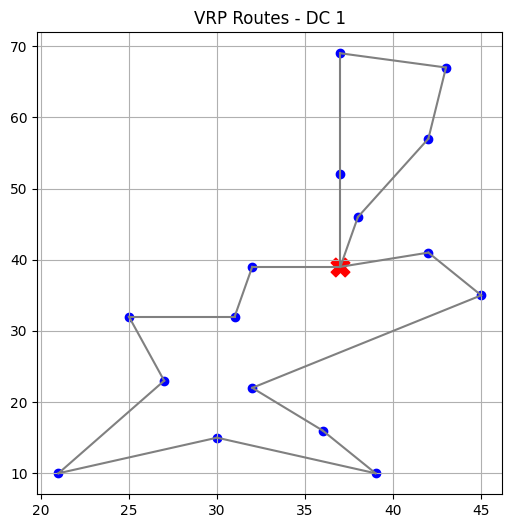


DC 2 | VRP 총 거리: 236
Routes: [[0, 17, 21, 16, 6, 20, 2, 7, 13, 0], [0, 8, 4, 3, 9, 18, 12, 19, 11, 0], [0, 10, 15, 5, 14, 1, 0]]


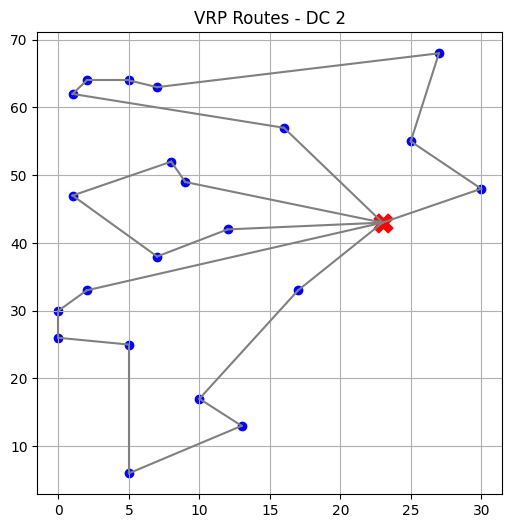


DC 3 | VRP 총 거리: 138
Routes: [[0, 2, 3, 10, 9, 5, 4, 0], [0, 13, 8, 6, 11, 7, 1, 12, 0]]


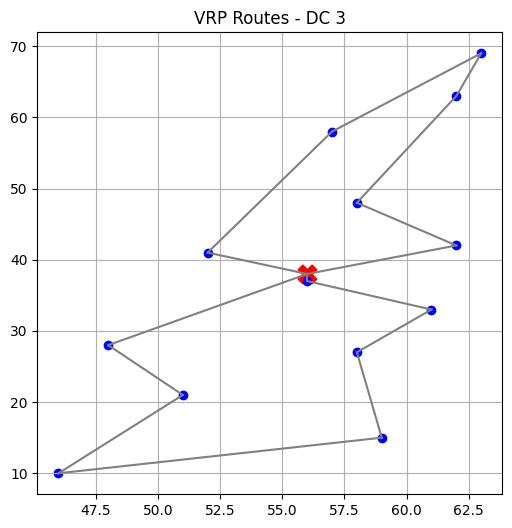


=========== 총 비용 ===========
개설된 센터: [1, 2, 3]
개설비용: 120
VRP 배송비: 541
👉 총비용: 661


In [12]:
# =========================================================
# CASE 1 : 균형 제약 포함 MILP + VRP + 시각화
# =========================================================

!pip install ortools pulp --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import pulp


# ---------------------------------------------------------
# 1) Load data
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index":"Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index":"DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

TRUCK_CAPACITY = truck["CAPACITY"].iloc[0]
OPEN_COST = dc["COST"].iloc[0]

# ---------------------------------------------------------
# 2) Euclidean distance
# ---------------------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)


# ---------------------------------------------------------
# 3) MILP for Center Opening + Customer Assignment
# ---------------------------------------------------------

model = pulp.LpProblem("FacilityLocation_Balanced", pulp.LpMinimize)

D = len(dc)
C = len(customer)

# Decision variables
y = pulp.LpVariable.dicts("OpenDC", range(D), cat="Binary")
x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

# Compute distance cost matrix
dist_cost = np.zeros((C, D))
for i, crow in customer.iterrows():
    for j, drow in dc.iterrows():
        dist_cost[i][j] = euclid((crow["X"], crow["Y"]), (drow["X"], drow["Y"]))

# Objective function: open cost + assignment cost
model += (
    pulp.lpSum([y[j] * OPEN_COST for j in range(D)]) +
    pulp.lpSum([x[i][j] * dist_cost[i][j] for i in range(C) for j in range(D)])
)


# ------------------------
# Constraints
# ------------------------

# (1) Each customer assigned to exactly 1 DC
for i in range(C):
    model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

# (2) Assignment allowed only if DC is open
for i in range(C):
    for j in range(D):
        model += x[i][j] <= y[j]

# (3) Balanced workload constraint
total_demand = customer["DEMAND"].sum()
max_allow = total_demand * 0.49      # 50%

for j in range(D):
    model += (
        pulp.lpSum([x[i][j] * customer["DEMAND"].iloc[i] for i in range(C)])
        <= max_allow
    )

# Solve MILP
model.solve(pulp.PULP_CBC_CMD(msg=False))

print("\n========== MILP 결과 ==========")
opened_centers = []
assignment = {}

for j in range(D):
    if y[j].value() == 1:
        opened_centers.append(j)

print("개설된 센터:", opened_centers)


# 고객 배정 결과 저장
for i in range(C):
    for j in range(D):
        if x[i][j].value() == 1:
            assignment[i] = j


# ---------------------------------------------------------
# 4) VRP 함수
# ---------------------------------------------------------
def solve_vrp(data, dist_matrix):
    manager = pywrapcp.RoutingIndexManager(
        len(dist_matrix), data["num_vehicles"], data["depot"]
    )
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return int(dist_matrix[f][t])

    cb = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(cb)

    # Capacity
    def demand_callback(from_idx):
        return data["demands"][manager.IndexToNode(from_idx)]

    demand_cb = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb,
        0,
        [data["vehicle_capacity"]]*data["num_vehicles"],
        True,
        "Capacity"
    )

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    sol = routing.SolveWithParameters(params)

    if not sol:
        return None, None

    total_dist = 0
    routes = []

    for v in range(data["num_vehicles"]):
        idx = routing.Start(v)
        route = []

        while not routing.IsEnd(idx):
            route.append(manager.IndexToNode(idx))
            prev = idx
            idx = sol.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(prev, idx, v)

        route.append(manager.IndexToNode(idx))
        if len(route) > 2:
            routes.append(route)

    return total_dist, routes


# ---------------------------------------------------------
# 5) VRP 실행 + 시각화
# ---------------------------------------------------------
vrp_results = {}
total_vrp_cost = 0

print("\n=========== VRP 결과 (Euclid) ==========")

for dc_id in opened_centers:

    cust_list = [i for i in range(C) if assignment[i] == dc_id]

    # depot + customer coords
    locs = []
    dc_row = dc.iloc[dc_id]
    locs.append((dc_row["X"], dc_row["Y"]))

    for cid in cust_list:
        row = customer.iloc[cid]
        locs.append((row["X"], row["Y"]))

    # distance matrix
    n = len(locs)
    dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]

    # demands
    demands = [0] + [customer.iloc[cid]["DEMAND"] for cid in cust_list]

    data = {
        "demands": demands,
        "num_vehicles": 5,
        "vehicle_capacity": TRUCK_CAPACITY,
        "depot": 0
    }

    total_dist, routes = solve_vrp(data, dist_matrix)
    vrp_results[dc_id] = total_dist
    total_vrp_cost += total_dist

    print(f"\nDC {dc_id} | VRP 총 거리: {total_dist}")
    print("Routes:", routes)

    # 그림
    plt.figure(figsize=(6,6))
    plt.scatter(dc_row["X"], dc_row["Y"], c="red", marker="X", s=180, label="DC")
    for cid in cust_list:
        row = customer.iloc[cid]
        plt.scatter(row["X"], row["Y"], c="blue")

    for r in routes:
        for i in range(len(r)-1):
            x1,y1 = locs[r[i]]
            x2,y2 = locs[r[i+1]]
            plt.plot([x1,x2],[y1,y2],c="gray")

    plt.title(f"VRP Routes - DC {dc_id}")
    plt.grid()
    plt.show()


# ---------------------------------------------------------
# 6) 총 비용 계산
# ---------------------------------------------------------
open_cost = len(opened_centers) * OPEN_COST
total_cost = open_cost + total_vrp_cost

print("\n=========== 총 비용 ===========")
print("개설된 센터:", opened_centers)
print("개설비용:", open_cost)
print("VRP 배송비:", total_vrp_cost)
print("👉 총비용:", total_cost)
print("================================")



====================== CASE 2 MILP 결과 ======================
개설된 센터: [1, 2, 3]

🚚 DC 1 | VRP 총 거리: 131
Routes: [[0, 13, 3, 5, 9, 11, 4, 12, 10, 2, 6, 7, 1, 8, 0]]


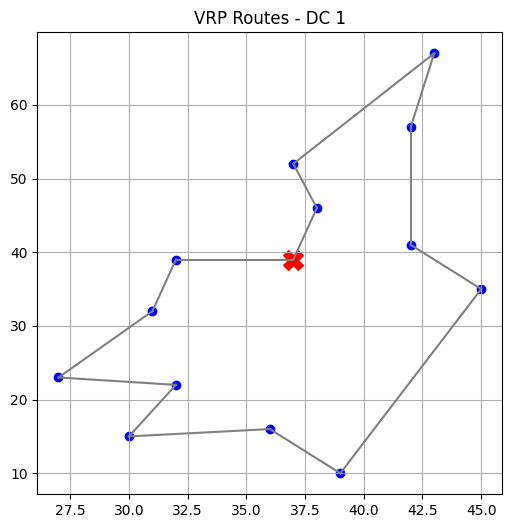


🚚 DC 2 | VRP 총 거리: 282
Routes: [[0, 10, 5, 7, 2, 22, 6, 16, 18, 24, 17, 0], [0, 11, 20, 19, 12, 21, 23, 0], [0, 13, 14, 1, 15, 8, 4, 3, 9, 0]]


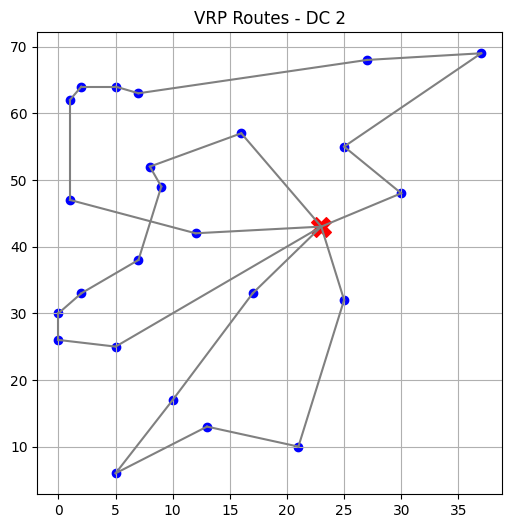


🚚 DC 3 | VRP 총 거리: 138
Routes: [[0, 2, 3, 10, 9, 5, 4, 0], [0, 13, 8, 6, 11, 7, 1, 12, 0]]


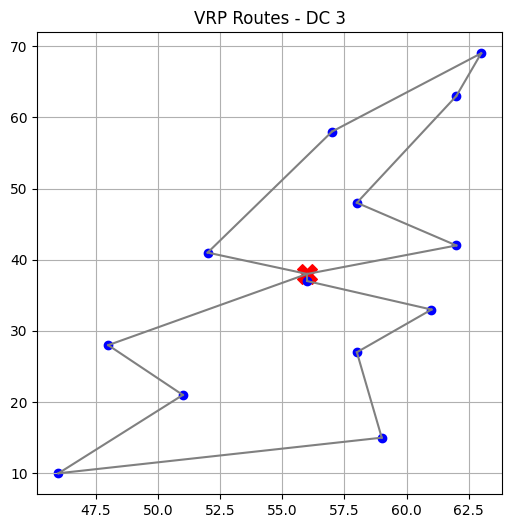


====================== CASE 2 총비용 ======================
개설된 센터: [1, 2, 3]
개설비용: 120
VRP 배송비: 551
👉 총 비용: 671


In [16]:
# =========================================================
# CASE 2 : 최소 수요 제약 MILP + VRP + 시각화 + 총비용
# =========================================================

!pip install ortools pulp --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import pulp


# ---------------------------------------------------------
# 1) Load data
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index":"Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index":"DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

OPEN_COST = dc["COST"].iloc[0]
TRUCK_CAPACITY = truck["CAPACITY"].iloc[0]
MIN_CUST = 5   # ⭐ "센터 열렸다면 최소 5명 담당"


# ---------------------------------------------------------
# 2) Euclidean Distance
# ---------------------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)



# ---------------------------------------------------------
# 3) MILP: Center Opening + Customer Assignment + 최소 수요 제약
# ---------------------------------------------------------
def solve_case2_milp():

    model = pulp.LpProblem("Case2_MinLoad", pulp.LpMinimize)

    C = len(customer)
    D = len(dc)

    # variables
    y = pulp.LpVariable.dicts("Open", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    # distance matrix
    dist_cost = np.zeros((C, D))
    for i, crow in customer.iterrows():
        for j, drow in dc.iterrows():
            dist_cost[i][j] = euclid((crow["X"], crow["Y"]), (drow["X"], drow["Y"]))

    # objective
    model += (
        pulp.lpSum([y[j] * OPEN_COST for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i][j] for i in range(C) for j in range(D)])
    )


    # -------------------------
    # CONSTRAINTS
    # -------------------------

    # 1) each customer assigned to exactly 1 DC
    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    # 2) assignment allowed only if DC is open
    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    # 3) ⭐ 최소 수요 제약: 열렸으면 최소 5명 담당
    for j in range(D):
        model += pulp.lpSum([x[i][j] for i in range(C)]) >= MIN_CUST * y[j]


    # Solve MILP
    status = model.solve(pulp.PULP_CBC_CMD(msg=False))

    if pulp.LpStatus[status] != "Optimal":
        print("❌ MILP infeasible!")
        return None, None

    # extract results
    opened_dc = []
    assignment = {}

    for j in range(D):
        if y[j].value() == 1:
            opened_dc.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() == 1:
                assignment[i] = j

    return opened_dc, assignment



# ---------------------------------------------------------
# 4) Solve VRP for a given DC
# ---------------------------------------------------------
def solve_vrp(dist_matrix, demands):

    manager = pywrapcp.RoutingIndexManager(len(dist_matrix), 5, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return int(dist_matrix[f][t])

    dist_cb = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb)

    # capacity constraint
    def demand_callback(from_index):
        return demands[manager.IndexToNode(from_index)]

    dem_cb = routing.RegisterUnaryTransitCallback(demand_callback)

    routing.AddDimensionWithVehicleCapacity(
        dem_cb,
        0,
        [TRUCK_CAPACITY] * 5,
        True,
        "Capacity"
    )

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    sol = routing.SolveWithParameters(params)
    if sol is None:
        return None, None

    # total route distance
    total_dist = 0
    routes = []

    for v in range(5):
        idx = routing.Start(v)
        route = []

        while not routing.IsEnd(idx):
            route.append(manager.IndexToNode(idx))
            prev = idx
            idx = sol.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(prev, idx, v)

        route.append(manager.IndexToNode(idx))
        if len(route) > 2:
            routes.append(route)

    return total_dist, routes



# ---------------------------------------------------------
# 5) Run VRP for all opened DCs and Plot
# ---------------------------------------------------------
def run_vrp_all(opened_dc, assignment):

    total_vrp_cost = 0
    vrp_output = {}

    for dc_id in opened_dc:

        cust_list = [i for i in assignment if assignment[i] == dc_id]

        locs = []
        dc_row = dc.iloc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))

        for cid in cust_list:
            c = customer.iloc[cid]
            locs.append((c["X"], c["Y"]))

        # distance matrix
        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]

        demands = [0] + [customer.iloc[c]["DEMAND"] for c in cust_list]

        # solve VRP
        vrp_cost, routes = solve_vrp(dist_matrix, demands)
        vrp_output[dc_id] = routes
        total_vrp_cost += vrp_cost

        print(f"\n🚚 DC {dc_id} | VRP 총 거리: {vrp_cost}")
        print("Routes:", routes)

        # plot
        plt.figure(figsize=(6,6))
        plt.scatter(dc_row["X"], dc_row["Y"], c="red", s=200, marker="X", label="DC")

        for cid in cust_list:
            c = customer.iloc[cid]
            plt.scatter(c["X"], c["Y"], c="blue")

        for r in routes:
            for k in range(len(r)-1):
                x1, y1 = locs[r[k]]
                x2, y2 = locs[r[k+1]]
                plt.plot([x1, x2], [y1, y2], 'gray')

        plt.title(f"VRP Routes - DC {dc_id}")
        plt.grid()
        plt.show()

    return total_vrp_cost



# ---------------------------------------------------------
# 6) RUN CASE 2
# ---------------------------------------------------------
opened_dc, assignment = solve_case2_milp()

print("\n====================== CASE 2 MILP 결과 ======================")
print("개설된 센터:", opened_dc)

# VRP 실행
total_vrp_cost = run_vrp_all(opened_dc, assignment)

# 총 비용 계산
open_cost = len(opened_dc) * OPEN_COST
total_cost = open_cost + total_vrp_cost

print("\n====================== CASE 2 총비용 ======================")
print("개설된 센터:", opened_dc)
print("개설비용:", open_cost)
print("VRP 배송비:", total_vrp_cost)
print("👉 총 비용:", total_cost)
print("===========================================================")


In [19]:
# =========================================================
# CASE 2 올인원 : 최소 수요 제약 + VRP + MIN_CUST 자동탐색
# =========================================================

!pip install ortools pulp --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import pulp


# ---------------------------------------------------------
# 1) Load data
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index":"Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index":"DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

OPEN_COST = dc["COST"].iloc[0]
TRUCK_CAPACITY = truck["CAPACITY"].iloc[0]


# ---------------------------------------------------------
# 2) Euclidean distance
# ---------------------------------------------------------
def euclid(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)



# ---------------------------------------------------------
# 3) ⭐ solve_milp_min_cust(K) 함수 정의 (자동탐색용)
# ---------------------------------------------------------
def solve_milp_min_cust(MIN_CUST):

    model = pulp.LpProblem("Case2_MinLoad", pulp.LpMinimize)
    C = len(customer)
    D = len(dc)

    y = pulp.LpVariable.dicts("Open", range(D), cat="Binary")
    x = pulp.LpVariable.dicts("Assign", (range(C), range(D)), cat="Binary")

    # distance matrix
    dist_cost = np.zeros((C, D))
    for i, crow in customer.iterrows():
        for j, drow in dc.iterrows():
            dist_cost[i][j] = euclid((crow["X"], crow["Y"]), (drow["X"], drow["Y"]))

    # objective
    model += (
        pulp.lpSum([y[j] * OPEN_COST for j in range(D)]) +
        pulp.lpSum([x[i][j] * dist_cost[i][j] for i in range(C) for j in range(D)])
    )

    # constraints
    for i in range(C):
        model += pulp.lpSum([x[i][j] for j in range(D)]) == 1

    for i in range(C):
        for j in range(D):
            model += x[i][j] <= y[j]

    # ⭐ 최소 고객 수 제약
    for j in range(D):
        model += pulp.lpSum([x[i][j] for i in range(C)]) >= MIN_CUST * y[j]

    status = model.solve(pulp.PULP_CBC_CMD(msg=False))

    if pulp.LpStatus[status] != "Optimal":
        return None, None

    opened = []
    assignment = {}

    for j in range(D):
        if y[j].value() == 1:
            opened.append(j)

    for i in range(C):
        for j in range(D):
            if x[i][j].value() == 1:
                assignment[i] = j

    return opened, assignment



# ---------------------------------------------------------
# 4) VRP solver
# ---------------------------------------------------------
def solve_vrp(dist_matrix, demands):

    manager = pywrapcp.RoutingIndexManager(len(dist_matrix), 5, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return int(dist_matrix[f][t])

    dist_cb = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb)

    def demand_callback(from_index):
        return demands[manager.IndexToNode(from_index)]

    dem_cb = routing.RegisterUnaryTransitCallback(demand_callback)

    routing.AddDimensionWithVehicleCapacity(
        dem_cb, 0, [TRUCK_CAPACITY] * 5, True, "Capacity"
    )

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    sol = routing.SolveWithParameters(params)
    if sol is None:
        return None, None

    total_dist = 0

    for v in range(5):
        idx = routing.Start(v)
        while not routing.IsEnd(idx):
            prev = idx
            idx = sol.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(prev, idx, v)

    return total_dist, None



# ---------------------------------------------------------
# 5) Evaluate VRP for all opened DCs
# ---------------------------------------------------------
def run_vrp_all(opened_dc, assignment):

    total = 0

    for dc_id in opened_dc:
        cust = [i for i in assignment if assignment[i] == dc_id]
        locs = []

        dc_row = dc.iloc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))

        for cid in cust:
            c = customer.iloc[cid]
            locs.append((c["X"], c["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands = [0] + [customer.iloc[c]["DEMAND"] for c in cust]

        vrp_cost, _ = solve_vrp(dist_matrix, demands)
        if vrp_cost is None:
            return None

        total += vrp_cost

    return total



# ---------------------------------------------------------
# 6) MIN_CUST 자동 탐색
# ---------------------------------------------------------
results = []

print("===== MIN_CUST(1~50) 자동탐색 시작 =====")

for K in range(1, 51):

    print(f"\n▶ MIN_CUST = {K} 탐색 중...")

    opened, assignment = solve_milp_min_cust(K)
    if opened is None:
        print(" - ❌ MILP infeasible")
        continue

    vrp_cost = run_vrp_all(opened, assignment)
    if vrp_cost is None:
        print(" - ❌ VRP infeasible")
        continue

    total_cost = len(opened) * OPEN_COST + vrp_cost

    print(f" - feasible! 총 비용 = {total_cost}")
    results.append([K, total_cost, opened])

valid = [r for r in results if r[1] is not None]

if len(valid) == 0:
    print("\n❌ feasible한 MIN_CUST 없음")
else:
    best = sorted(valid, key=lambda x: x[1])[0]
    print("\n================= 결과 =================")
    print("최적 MIN_CUST =", best[0])
    print("총 비용 =", best[1])
    print("개설된 센터 =", best[2])


===== MIN_CUST(1~50) 자동탐색 시작 =====

▶ MIN_CUST = 1 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 2 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 3 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 4 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 5 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 6 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 7 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 8 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 9 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 10 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 11 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 12 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 13 탐색 중...
 - feasible! 총 비용 = 671

▶ MIN_CUST = 14 탐색 중...
 - feasible! 총 비용 = 661

▶ MIN_CUST = 15 탐색 중...
 - feasible! 총 비용 = 681

▶ MIN_CUST = 16 탐색 중...
 - feasible! 총 비용 = 601

▶ MIN_CUST = 17 탐색 중...
 - feasible! 총 비용 = 596

▶ MIN_CUST = 18 탐색 중...
 - feasible! 총 비용 = 601

▶ MIN_CUST = 19 탐색 중...
 - feasible! 총 비용 = 602

▶ MIN_CUST = 20 탐색 중...
 - feasible! 총 비용 

In [26]:
def solve_vrp_with_routes(dist_matrix, demands):

    manager = pywrapcp.RoutingIndexManager(len(dist_matrix), 5, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return int(dist_matrix[f][t] * 100)  # 거리 정수 스케일링

    dist_cb = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb)

    def demand_callback(from_idx):
        return demands[manager.IndexToNode(from_idx)]

    dem_cb = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        dem_cb, 0, [TRUCK_CAPACITY] * 5, True, "Capacity"
    )

    params = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search = pywrapcp.DefaultRoutingSearchParameters()
    search.first_solution_strategy = params

    sol = routing.SolveWithParameters(search)
    if sol is None:
        return None, None

    total_dist = 0
    routes = []

    for v in range(5):
        idx = routing.Start(v)
        route = []

        while not routing.IsEnd(idx):
            node = manager.IndexToNode(idx)
            route.append(node)

            prev = idx
            idx = sol.Value(routing.NextVar(idx))
            total_dist += routing.GetArcCostForVehicle(prev, idx, v)

        route.append(manager.IndexToNode(idx))

        if len(route) > 2:
            routes.append(route)

    return total_dist / 100, routes


In [27]:
def plot_vrp_routes(locs, routes, dc_id):
    plt.figure(figsize=(7,7))

    # depot
    dx, dy = locs[0]
    plt.scatter(dx, dy, c="red", marker="X", s=200, label=f"DC {dc_id}")

    # customers
    for idx, (x,y) in enumerate(locs[1:], start=1):
        plt.scatter(x, y, c="blue")
        plt.text(x+0.2, y+0.2, str(idx), fontsize=9)

    colors = ["green", "purple", "orange", "brown", "pink"]

    # plot routes
    for r_idx, route in enumerate(routes):
        col = colors[r_idx % len(colors)]
        for i in range(len(route)-1):
            x1, y1 = locs[route[i]]
            x2, y2 = locs[route[i+1]]
            plt.plot([x1, x2], [y1, y2], color=col, linewidth=2)

    plt.title(f"VRP Routes for DC {dc_id}")
    plt.grid(alpha=0.3)
    plt.show()


개설된 센터: [2, 3]

DC 2 | 총 VRP 거리 = 321.25
Routes: [[0, 28, 10, 13, 22, 27, 25, 15, 23, 24, 29, 0], [0, 30, 19, 21, 1, 20, 0], [0, 14, 11, 4, 5, 9, 18, 12, 0], [0, 16, 7, 26, 3, 8, 6, 17, 2, 0]]


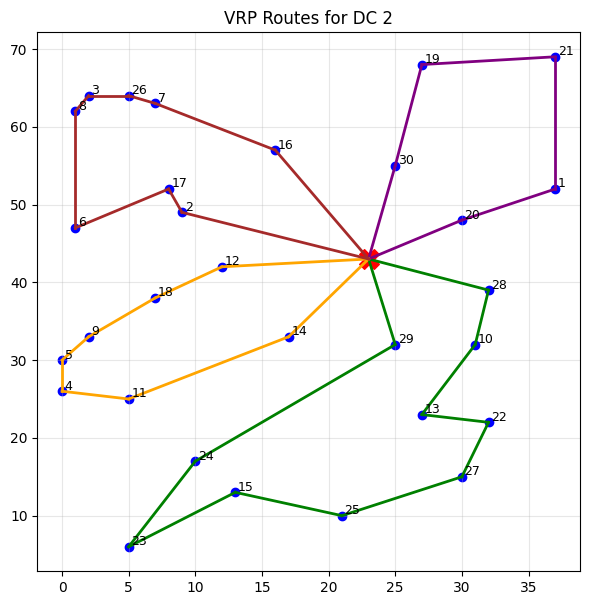


DC 3 | 총 VRP 거리 = 196.64
Routes: [[0, 20, 19, 1, 3, 18, 12, 17, 10, 13, 0], [0, 4, 16, 2, 11, 7, 8, 15, 14, 5, 9, 6, 0]]


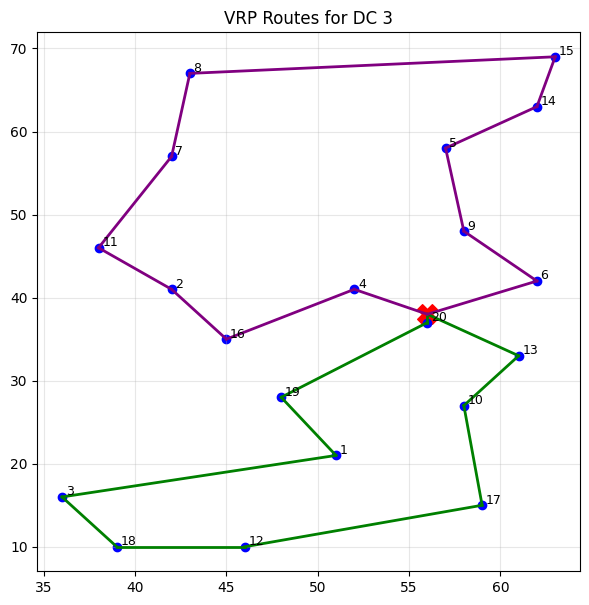

In [28]:
# MIN_CUST = 20 고정
opened_20, assign_20 = solve_milp_min_cust(20)

print("개설된 센터:", opened_20)

for dc_id in opened_20:
    cust_list = [i for i in assign_20 if assign_20[i] == dc_id]

    # depot + customer 좌표 생성
    locs = []
    dc_row = dc.iloc[dc_id]
    locs.append((dc_row["X"], dc_row["Y"]))

    for cid in cust_list:
        row = customer.iloc[cid]
        locs.append((row["X"], row["Y"]))

    # 거리행렬 & demands
    n = len(locs)
    dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
    demands = [0] + [customer.iloc[c]["DEMAND"] for c in cust_list]

    # VRP 실행
    dist, routes = solve_vrp_with_routes(dist_matrix, demands)

    print(f"\nDC {dc_id} | 총 VRP 거리 = {dist}")
    print("Routes:", routes)

    # 시각화
    plot_vrp_routes(locs, routes, dc_id)


In [29]:
# ------------------------------
# 총비용 계산
# ------------------------------
open_cost = len(opened_20) * OPEN_COST
total_cost = open_cost + total_vrp_cost

print("\n====================== 총 비용 ======================")
print("개설된 센터:", opened_20)
print("개설비용:", open_cost)
print("VRP 배송비:", total_vrp_cost)
print("👉 총 비용:", total_cost)
print("======================================================")


====================== 총 비용 ======================
개설된 센터: [2, 3]
개설비용: 80
VRP 배송비: 551
👉 총 비용: 631


# **case 3**

In [39]:
def search_best_case3():

    lambda_list = [round(x, 2) for x in np.arange(0.30, 0.61, 0.02)]
    mincust_list = [5, 10, 15, 20, 25, 30]

    results = []

    print("\n====== CASE 3: λ × MIN_CUST 자동 탐색 시작 ======\n")

    for lam in lambda_list:
        for K in mincust_list:

            print(f"▶ λ={lam}, MIN_CUST={K} 탐색 중...")

            opened, assignment = solve_milp_case3(lam, K)
            if opened is None:
                print("  - MILP infeasible")
                continue

            vrp_cost = run_vrp_all(opened, assignment)
            if vrp_cost is None:
                print("  - VRP infeasible")
                continue

            total_cost = OPEN_COST * len(opened) + vrp_cost

            print(f"  - feasible! 총비용 = {total_cost}")

            results.append([lam, K, total_cost, opened, assignment])

    valid = [r for r in results if r[2] is not None]
    best = sorted(valid, key=lambda x: x[2])[0]

    print("\n====== CASE 3 최종 최적 결과 ======")
    print("⭐ 최적 λ =", best[0])
    print("⭐ 최적 MIN_CUST =", best[1])
    print("⭐ 최소 총비용 =", best[2])
    print("⭐ 개설 센터 =", best[3])

    return best


In [40]:
def run_case3_best():

    lam, K, mincost, opened, assignment = search_best_case3()

    print(f"\n==== 최적 조합으로 VRP 실행 (λ={lam}, MIN_CUST={K}) ====\n")

    total_vrp_cost = 0

    for dc_id in opened:

        cust_list = [i for i in assignment if assignment[i] == dc_id]

        locs = []
        dc_row = dc.iloc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))
        for cid in cust_list:
            row = customer.iloc[cid]
            locs.append((row["X"], row["Y"]))

        # 거리 행렬
        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands = [0] + [customer.iloc[c]["DEMAND"] for c in cust_list]

        vrp_dist, routes = solve_vrp_routes(dist_matrix, demands)

        print(f"DC {dc_id} | VRP 거리 = {vrp_dist}")
        print("Routes:", routes)

        total_vrp_cost += vrp_dist

        plot_vrp(locs, routes, dc_id)

    open_cost = len(opened)*OPEN_COST
    total_cost = open_cost + total_vrp_cost

    print("\n===== 최종 총비용 =====")
    print("개설비용:", open_cost)
    print("VRP 비용:", total_vrp_cost)
    print("👉 총비용:", total_cost)



====== CASE 3: λ × MIN_CUST 자동 탐색 시작 ======

▶ λ=0.3, MIN_CUST=5 탐색 중...
  - feasible! 총비용 = 671
▶ λ=0.3, MIN_CUST=10 탐색 중...
  - feasible! 총비용 = 671
▶ λ=0.3, MIN_CUST=15 탐색 중...
  - feasible! 총비용 = 681
▶ λ=0.3, MIN_CUST=20 탐색 중...
  - feasible! 총비용 = 580
▶ λ=0.3, MIN_CUST=25 탐색 중...
  - feasible! 총비용 = 615
▶ λ=0.3, MIN_CUST=30 탐색 중...
  - feasible! 총비용 = 635
▶ λ=0.32, MIN_CUST=5 탐색 중...
  - feasible! 총비용 = 671
▶ λ=0.32, MIN_CUST=10 탐색 중...
  - feasible! 총비용 = 671
▶ λ=0.32, MIN_CUST=15 탐색 중...
  - feasible! 총비용 = 681
▶ λ=0.32, MIN_CUST=20 탐색 중...
  - feasible! 총비용 = 580
▶ λ=0.32, MIN_CUST=25 탐색 중...
  - feasible! 총비용 = 615
▶ λ=0.32, MIN_CUST=30 탐색 중...
  - feasible! 총비용 = 635
▶ λ=0.34, MIN_CUST=5 탐색 중...
  - feasible! 총비용 = 671
▶ λ=0.34, MIN_CUST=10 탐색 중...
  - feasible! 총비용 = 671
▶ λ=0.34, MIN_CUST=15 탐색 중...
  - feasible! 총비용 = 681
▶ λ=0.34, MIN_CUST=20 탐색 중...
  - feasible! 총비용 = 580
▶ λ=0.34, MIN_CUST=25 탐색 중...
  - feasible! 총비용 = 615
▶ λ=0.34, MIN_CUST=30 탐색 중...
  - feasible! 총

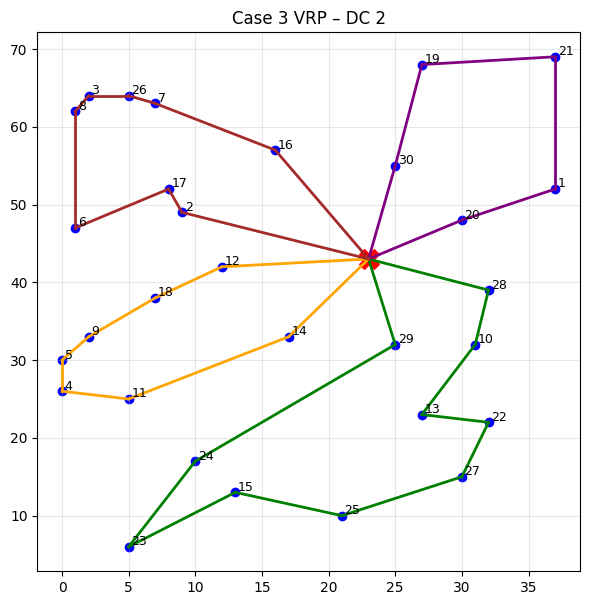

DC 3 | VRP 거리 = 196.64
Routes: [[0, 20, 19, 1, 3, 18, 12, 17, 10, 13, 0], [0, 4, 16, 2, 11, 7, 8, 15, 14, 5, 9, 6, 0]]


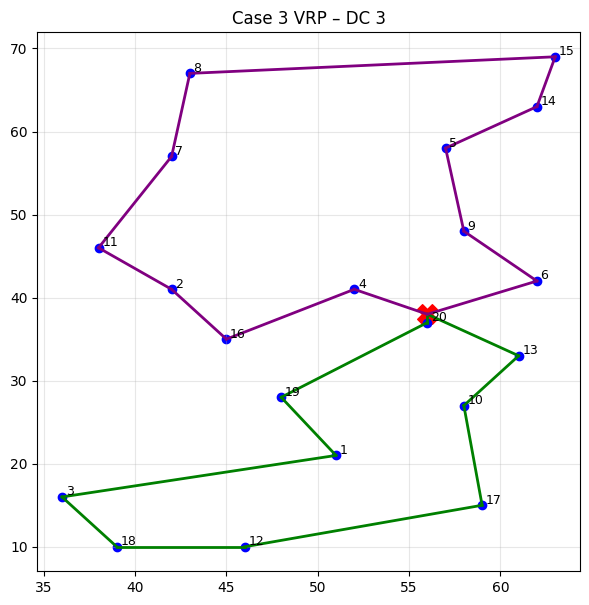


===== 최종 총비용 =====
개설비용: 80
VRP 비용: 517.89
👉 총비용: 597.89


In [41]:
run_case3_best()
